In [1]:
import sys
import os
import copy
from abc import ABC, abstractmethod
import math
import copy
from copy import deepcopy
import PIL
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import torchvision
import torchvision.models as torchmodels
import torch.nn.functional as F
import openslide
import torch.utils.data

list_pathstoadd = ["../../"]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
import pydmed
from pydmed.utils.data import *
import pydmed.lightdl
from pydmed.lightdl import *
import pydmed.extensions.wsi
import pydmed.streamcollector

In [2]:
#settings ====
kernel_size = 2000

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#make the model ====
module_resnet = torchvision.models.resnet18(pretrained=True)
list_modules = list(module_resnet.children())[0:-2]
model = torch.nn.Sequential(*list_modules)

def func_setpaddingmodes_for_conv2dlayers(module_input, str_paddingmode):
    '''
    Sets the padding mode of all conv2d modules, either on imediate children or non-imediate children.
    '''
    #get num_children
    num_children = 0
    for child in module_input.children():
        num_children += 1
    
    #base case, the module has no children ====
    if(num_children == 0):
        if(isinstance(module_input, torch.nn.Conv2d)):
            module_input.padding_mode = str_paddingmode
        return module_input
        
    #non-base case, loop over children ====
    for child in module_input.children():
        func_setpaddingmodes_for_conv2dlayers(child, str_paddingmode)
    return module_input

model = func_setpaddingmodes_for_conv2dlayers(model, "reflect") #set paddingmode to "reflect"

In [5]:
#make dataset ===================
rootdir = "../../NonGit/Data/Sample3Heatmap/"
list_relativedirs = ["1.tif", "2.tif", "3.tif", "4.tif", "5.tif",\
                     "6.tif", "7.tif", "8.tif", "9.tif", "10.tif"]
list_relativedirs.sort()
#make a list of patients
list_patients = []
for fname in list_relativedirs:
    new_patient = Patient(\
            int_uniqueid = list_relativedirs.index(fname),
            dict_records = {
                "H&E":Record(rootdir, fname, {"resolution":"40x"}),
                "somelabel": np.random.randint(0,4)
             }
         )
    list_patients.append(new_patient)
#make the dataset
dataset = pydmed.utils.data.Dataset("dataset_sample3Heatmap", list_patients)

In [6]:
tfms_onsmallchunkcollection =\
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),\
        torchvision.transforms.ToTensor(),\
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],\
                                         std=[0.229, 0.224, 0.225])
    ])
tfms_oncolate = torchvision.transforms.ToTensor()
const_global_info = {
    "attention_levelidx":1,
    "num_bigchunkloaders":5,
    "maxlength_queue_smallchunk":np.inf,
    "maxlength_queue_lightdl":np.inf,
    "interval_resched": 2,
    "core-assignment":{
                "lightdl":None,
                "smallchunkloaders":None,
                "bigchunkloaders":None
              }
    }

In [7]:
dl_forheatmap = pydmed.extensions.wsi.SlidingWindowDL(
          intorfunc_opslevel = 1,
          kernel_size = kernel_size,
          stride = kernel_size,
          mininterval_loadnewbigchunk = 15,
          dataset = dataset,\
          type_bigchunkloader=pydmed.extensions.wsi.SlidingWindowBigChunkLoader,\
          type_smallchunkcollector=pydmed.extensions.wsi.SlidingWindowSmallChunkCollector,\
          const_global_info=const_global_info,\
          batch_size=1,\
          tfms_onsmallchunkcollection=tfms_onsmallchunkcollection,\
          tfms = tfms_oncolate,
          flag_grabqueue_onunsched = True
    )

In [8]:
import pydmed.streamcollector
from pydmed.streamcollector import *

class HeatmapStreamCollector(StreamCollector):
    def __init__(self, module_pipeline, device, *args, **kwargs):
        #grab privates
        self.module_pipeline = module_pipeline
        self.device = device
        #make other initial operations
        self.module_pipeline.to(device)
        self.module_pipeline.eval()
        self.num_calls_to_getflagfinished = 0
        super(HeatmapStreamCollector, self).__init__(*args, **kwargs)
        
        
    @abstractmethod
    def process_pieceofstream(self, retval_collatefunc):
        x, list_patients, list_smallchunks = retval_collatefunc
        with torch.no_grad():
            netout = \
                self.module_pipeline(x.to(self.device))#[32x1x7x7]
            list_processedpiece = []
            for n in range(netout.shape[0]):
                tensor_piecen = netout[n,0,:,:].unsqueeze(0)
                str_piecen = pydmed.extensions.wsi.Tensor3DtoPdmcsvrow(
                                tensor_piecen.detach().cpu().numpy(), list_smallchunks[n]
                            )
                list_processedpiece.append(
                                   ProcessedPiece(
                                      data = str_piecen,\
                                      source_smallchunk = list_smallchunks[n]
                                    )
                                 )
        return list_processedpiece
    
    @abstractmethod
    def get_flag_finishcollecting(self):
        self.num_calls_to_getflagfinished += 1
        is_dl_running = self.lightdl.is_dl_running()
        if((is_dl_running==False) and (self.lightdl.queue_lightdl.qsize()==0)):
            return True
        else:
            return False

In [9]:
statcollector = HeatmapStreamCollector(
                module_pipeline=model,
                device = device,
                lightdl = dl_forheatmap,
                str_collectortype = "stream_to_file",
                flag_visualizestats= False,
                kwargs_streamwriter = {
                    "rootpath": "./Output/GeneratedHeatmaps/",
                    "fname_tosave":None, 
                    "waiting_time_before_flush":3
                }
            )

In [10]:
statcollector.start_collecting()

 loading initial bigchunks, please wait ....
     bigchunk 0 from 5, please wait ...

     bigchunk 1 from 5, please wait ...

     bigchunk 2 from 5, please wait ...orking .....  (printed on 16-06-2021-22:56:05)

     bigchunk 3 from 5, please wait ...orking .....  (printed on 16-06-2021-22:56:10)

     bigchunk 4 from 5, please wait ...orking .....  (printed on 16-06-2021-22:56:21)

The initial loading of bigchunks took 46.83195495605469 seconds. 16-06-2021-22:56:31)
extractbigchunk failed for patient utils.data.Patient with unique id: 7.021-01:21:00)

extractbigchunk failed for patient utils.data.Patient with unique id: 7.021-01:21:45) .....  (printed on 17-06-2021-01:21:05)
cannot convert float infinity to integer
extractbigchunk failed for patient utils.data.Patient with unique id: 4.021-01:23:23)
cannot convert float infinity to integer
extractbigchunk failed for patient utils.data.Patient with unique id: 8.021-01:25:51)
cannot convert float infinity to integer
an exception occur

idx_patient = 0


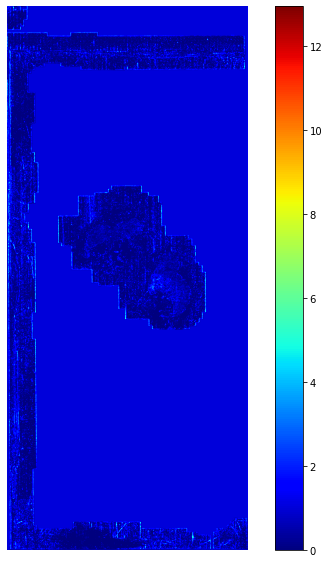



idx_patient = 1


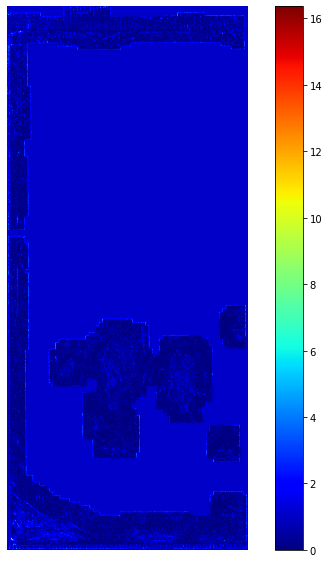



idx_patient = 2


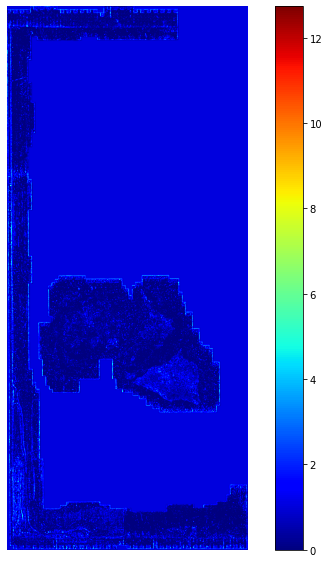



idx_patient = 3


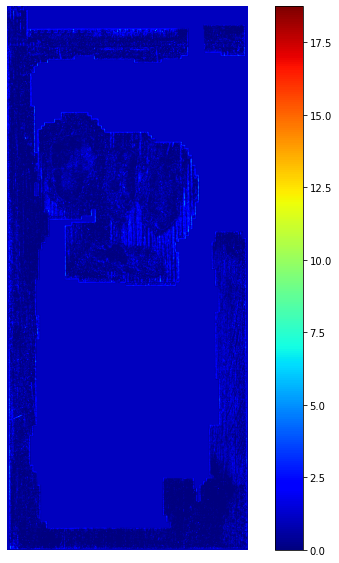



idx_patient = 4


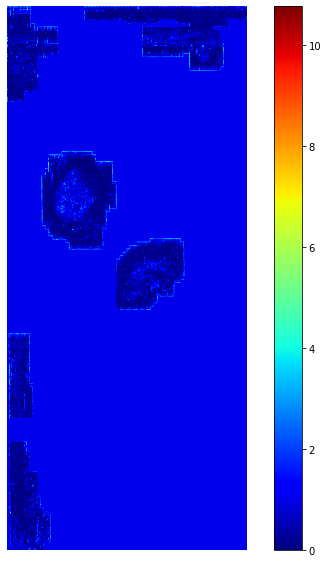



idx_patient = 5


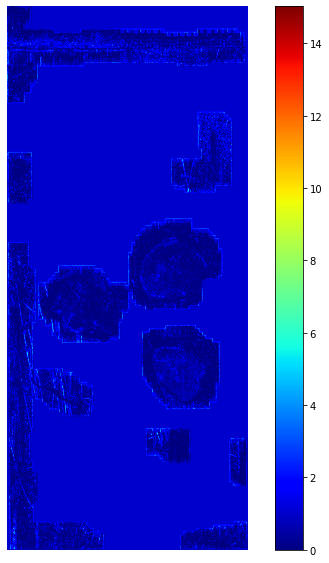



idx_patient = 6


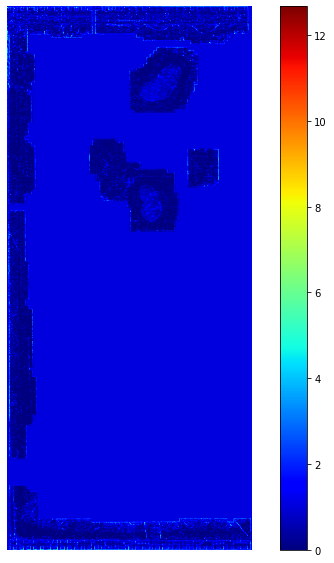



idx_patient = 7


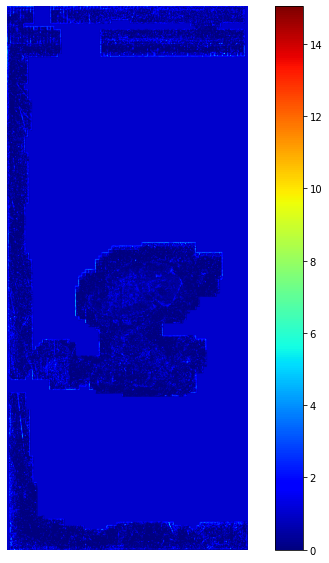



idx_patient = 8


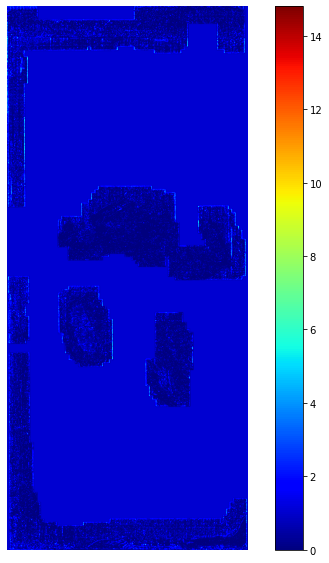



idx_patient = 9


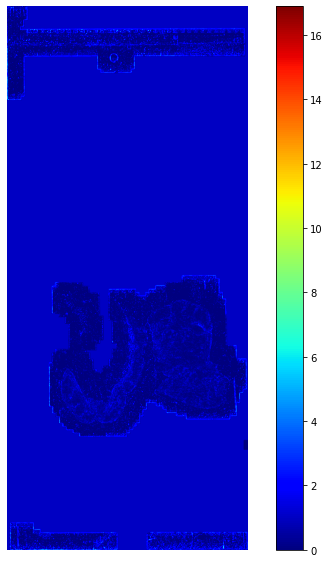

In [11]:
#make the default raster to WSI
default_wsitoraster = pydmed.extensions.wsi.DefaultWSIxyWHvaltoRasterPoints()

list_paddedregions = []
for patient in dataset.list_patients:
    print("idx_patient = {}".format(patient.int_uniqueid))
    fname_pdmcsv = "Output/GeneratedHeatmaps/patient_{}.csv".format(
                        patient.int_uniqueid
                     )
    np_heatmap = pydmed.extensions.wsi.pdmcsvtoarray(
                        fname_pdmcsv,
                        default_wsitoraster.func_WSIxyWHval_to_rasterpoints,
                        scale_upsampleraster = 1.0
                    )
    plt.figure(figsize=(10,10))
    plt.imshow(np_heatmap[:,:,0], cmap="jet")
    plt.colorbar()
    plt.axis("off")
    plt.savefig(
            "Output/FromNdarraytoImage/patient_{}.png".format(patient.int_uniqueid),
             dpi=100, pad_inches=0, bbox_inches="tight"
            )
    plt.show()
    
    np.save(
        "Output/FromNdarraytoImage/patient_{}".format(patient.int_uniqueid),
         np_heatmap
      )
    print("\n")
    